# 自我注意力和位置编码
:label:`sec_self-attention-and-positional-encoding`

在深度学习中，我们经常使用 CNN 或 RNN 对序列进行编码。现在请注意机制。想象一下，我们将一系列令牌输入注意力池，以便同一组令牌充当查询、键和值。具体来说，每个查询都会关注所有键值对并生成一个注意力输出。由于查询、键和值来自同一个地方，因此执行
*自我关注 * :cite:`Lin.Feng.Santos.ea.2017,Vaswani.Shazeer.Parmar.ea.2017`，也称为 * 内心注意 * :cite:`Cheng.Dong.Lapata.2016,Parikh.Tackstrom.Das.ea.2016,Paulus.Xiong.Socher.2017`。
在本节中，我们将讨论使用自我注意的序列编码，包括使用序列顺序的其他信息。


In [1]:
import math
from mxnet import autograd, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## 自我注意

给定一系列输入令牌 $\mathbf{x}_1, \ldots, \mathbf{x}_n$，其中任何 $\mathbf{x}_i \in \mathbb{R}^d$ ($1 \leq i \leq n$)，它的自我注意力输出一个长度相同的序列 $\mathbf{y}_1, \ldots, \mathbf{y}_n$，其中

$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$$

根据 :eqref:`eq_attn-pooling` 中关注集中 $f$ 的定义。使用多头注意力，以下代码片段计算具有形状的张量的自我注意力（批量大小、时间步长或令牌中的序列长度，$d$）。输出张量的形状相同。


In [2]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
attention.initialize()

In [3]:
batch_size, num_queries, valid_lens = 2, 4, np.array([3, 2])
X = np.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

(2, 4, 100)

## 比较 CNN、RNN 和自我注意
:label:`subsec_cnn-rnn-self-attention`

让我们比较将 $n$ 令牌序列映射到另一个相等长度序列的架构，其中每个输入或输出令牌由 $d$ 维矢量表示。具体来说，我们将考虑 CNN、RNN 和自我注意力。我们将比较它们的计算复杂性、顺序操作和最大路径长度。请注意，顺序操作会阻止并行计算，而任意序列位置组合之间的路径较短，可以更轻松地学习序列 :cite:`Hochreiter.Bengio.Frasconi.ea.2001` 中的远距离依赖关系。

![Comparing CNN (padding tokens are omitted), RNN, and self-attention architectures.](../img/cnn-rnn-self-attention.svg)
:label:`fig_cnn-rnn-self-attention`

考虑一个内核大小为 $k$ 的卷积层。我们将在后面的章节中提供有关使用 CNN 处理序列的更多详细信息目前，我们只需要知道，由于序列长度是 $n$，所以输入和输出通道的数量都是 $d$，卷积层的计算复杂度为 $\mathcal{O}(knd^2)$。如 :numref:`fig_cnn-rnn-self-attention` 所示，CNN 是分层的，因此有 $\mathcal{O}(1)$ 个顺序操作，最大路径长度为 $\mathcal{O}(n/k)$。例如，$\mathbf{x}_1$ 和 $\mathbf{x}_5$ 处于 :numref:`fig_cnn-rnn-self-attention` 中内核大小为 3 的双层 CNN 的接受范围内。

更新 rnN 的隐藏状态时，$d \times d$ 权重矩阵和 $d$ 维隐藏状态的乘法计算复杂度为 $\mathcal{O}(d^2)$。由于序列长度为 $n$，因此循环层的计算复杂度为 $\mathcal{O}(nd^2)$。根据 :numref:`fig_cnn-rnn-self-attention`，有 $\mathcal{O}(n)$ 个顺序操作无法并行化，最大路径长度也是 $\mathcal{O}(n)$。

在自我注意中，查询、键和值都是 $n \times d$ 矩阵。考虑 :eqref:`eq_softmax_QK_V` 中的扩展点-产品关注点，其中 $n \times d$ 矩阵乘以 $d \times n$ 矩阵，然后输出 $n \times n$ 矩阵乘以 $n \times d$ 矩阵。因此，自我注意力具有 $\mathcal{O}(n^2d)$ 计算复杂性。正如我们在 :numref:`fig_cnn-rnn-self-attention` 中看到的那样，每个令牌都通过自我注意直接连接到任何其他令牌。因此，计算可以与 $\mathcal{O}(1)$ 顺序操作并行，最大路径长度也是 $\mathcal{O}(1)$。

总而言之，CNN 和自我注意力都可以享受并行计算，而且自我注意力的最大路径长度最短。但是，相对于序列长度的二次计算复杂性使得自我注意力在很长的序列中非常缓慢。

## 位置编码
:label:`subsec_positional-encoding`

与逐个重复处理序列令牌的 RNN 不同，自我注意力会放弃顺序操作，而倾向于并行计算。要使用序列顺序信息，我们可以通过在输入表示中添加 * 位置编码 * 来注入绝对或相对位置信息。可以学习或修复位置编码。在下面，我们描述了基于正弦和余弦函数 :cite:`Vaswani.Shazeer.Parmar.ea.2017` 的固定位置编码。

假设输入表示 $\mathbf{X} \in \mathbb{R}^{n \times d}$ 包含一个序列中 $n$ 令牌的 $d$ 维嵌入。位置编码使用相同形状的位置嵌入矩阵 $\mathbf{P} \in \mathbb{R}^{n \times d}$ 输出 $\mathbf{X} + \mathbf{P}$，该矩阵在 $i^\mathrm{th}$ 行和 $(2j)^\mathrm{th}$ 或 $(2j + 1)^\mathrm{th}$ 列上的元素为

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$
:eqlabel:`eq_positional-encoding-def`

乍一看，这种三角函数设计看起来很奇怪。在解释这个设计之前，让我们首先在下面的 `PositionalEncoding` 课中实现它。


In [4]:
#@save
class PositionalEncoding(nn.Block):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = np.zeros((1, max_len, num_hiddens))
        X = np.arange(max_len).reshape(-1, 1) / np.power(
            10000,
            np.arange(0, num_hiddens, 2) / num_hiddens)
        self.P[:, :, 0::2] = np.sin(X)
        self.P[:, :, 1::2] = np.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].as_in_ctx(X.ctx)
        return self.dropout(X)

在位置嵌入矩阵 $\mathbf{P}$ 中，行对应于序列中的位置，列表示不同的位置编码维度。在下面的示例中，我们可以看到位置嵌入矩阵的 $6^{\mathrm{th}}$ 和 $7^{\mathrm{th}}$ 列的频率高于 $8^{\mathrm{th}}$ 和 $9^{\mathrm{th}}$ 列。$6^{\mathrm{th}}$ 和 $7^{\mathrm{th}}$ 列之间的偏移量（$8^{\mathrm{th}}$ 和 $9^{\mathrm{th}}$ 列相同）是由于正弦函数和余弦函数的交替。


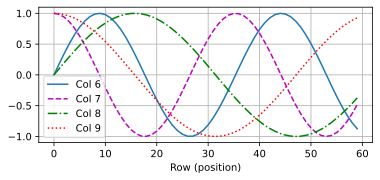

In [5]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.initialize()
X = pos_encoding(np.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(np.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in np.arange(6, 10)])

### 绝对位置信息

要了解沿编码维度单调降低的频率与绝对位置信息的关系，让我们打印出 $0, 1, \ldots, 7$ 的二进制表示形式。正如我们所看到的，每个数字、每两个数字和每四个数字上的最低位、第二位和第三位最低位分别交替。


In [6]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


在二进制表示中，较高的位比特的频率低于较低的位。同样，如下面的热图所示，位置编码通过使用三角函数在编码维度下降频率。由于输出是浮点数，因此此类连续表示比二进制表示法更节省空间。


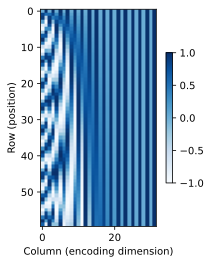

In [7]:
P = np.expand_dims(np.expand_dims(P[0, :, :], 0), 0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

### 相对位置信息

除了捕获绝对位置信息之外，上述位置编码还允许模型轻松学习相对位置参加。这是因为对于任何固定仓位偏移 $\delta$，位置 $i + \delta$ 处的位置编码可以用 $i$ 位置的线性投影来表示。

这种预测可以用数学方式解释。代表 $\omega_j = 1/10000^{2j/d}$，对于任何固定抵消量 $\delta$，:eqref:`eq_positional-encoding-def` 中的任何一对 $(p_{i, 2j}, p_{i, 2j+1})$ 都可以线性预测到 $(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$：

$$\begin{aligned}
&\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}\\
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}$$

$2\times 2$ 预测矩阵不依赖于任何仓位指数 $i$。

## 摘要

* 在自我注意中，查询、键和值都来自同一个地方。
* CNN 和自我注意都享受并行计算，自我注意力的最大路径长度最短。但是，相对于序列长度的二次计算复杂性使得自我注意力在很长的序列中非常缓慢。
* 要使用序列顺序信息，我们可以通过在输入表示中添加位置编码来注入绝对或相对位置信息。

## 练习

1. 假设我们设计了一个深层架构，通过使用位置编码堆叠自我注意图层来表示序列。可能是什么问题？
1. 你能设计一种可学习的位置编码方法吗？


[Discussions](https://discuss.d2l.ai/t/1651)
